In [134]:
using DifferentialEquations, LinearAlgebra, Plots, LaTeXStrings

# RLC Circuit

The differential equation for current in a driven series RLC circuit is given by

$$V(t) = L \dot{I} + I R + Q C^{-1}$$

Taking a derivative with the assumption inductance is time-independent and the current source is given by $V_0 \sin(\omega t)$ we get a second order differential equation for current.

$$\ddot{I} = \left( - R \dot{I} - I C^{-1} + \omega V_0 \cos(\omega t) \right) / L$$

## Parameters

In [135]:
const V₀ = 1.0
const Q = 1000.0
const C = 1.0
const L = 1.0
const R = sqrt(L / C) / Q

0.001

In [136]:
const ω₀ = 1 / sqrt(L * C)

1.0

## Problem Setup

In [193]:
function RLC(ddI, dI, I, ω, t)
    @. ddI = (-R * dI - I / C + ω * V₀ * cos(ω * t)) / L
end

RLC (generic function with 1 method)

In [194]:
tspan = (0.0, 50.0)
alg = VerletLeapfrog()
dt = 0.01;

In [195]:
prob = SecondOrderODEProblem(RLC, [0.0], [0.0], tspan, π / 4)

ODEProblem with uType ArrayPartition{Float64,Tuple{Array{Float64,1},Array{Float64,1}}} and tType Float64. In-place: true
timespan: (0.0, 50.0)
u0: [0.0][0.0]

In [196]:
sol = solve(prob, alg, dt=dt);

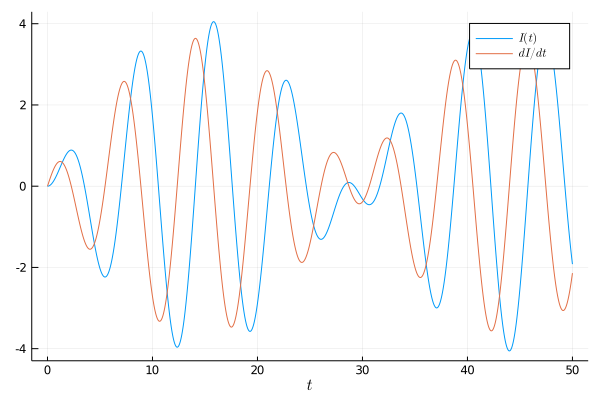

In [197]:
plot(sol.t, sol[2,:], label=L"I(t)", xlabel=L"t")
plot!(sol.t, sol[1,:], label=L"dI/dt")

## Resonance Sweep

In [198]:
ωs = 0:0.01:π
peaks = Vector{Float64}(undef, length(ωs))
for (i, ω) in enumerate(ωs)
    probe = SecondOrderODEProblem(RLC, [0.0], [0.0], tspan, ω)
    solv = solve(probe, alg, dt=dt)
    peaks[i] = maximum(solv[2,:])
end

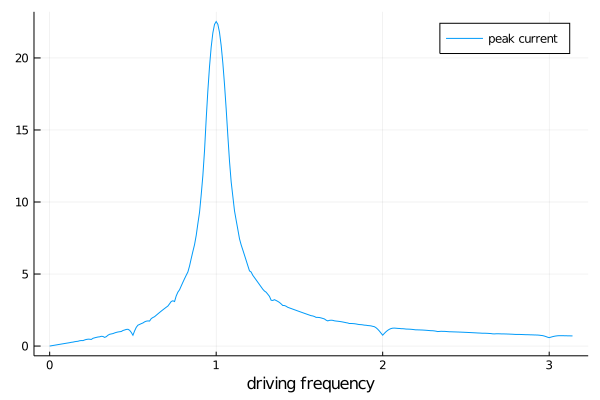

In [203]:
plot(ωs, peaks, label="peak current", xlabel="driving frequency")

# Qubit Circuit

By replacing the inductor in the RLC circuit with a Josephson Junction, we get a time-dependent inductance defined as

$$L_J (I(t)) = \frac{\Phi_0}{2\pi \sqrt{I_c^2- I^2(t)}}$$

Which gives us the following differential equation to solve for $I$

$$\ddot{I} = \left(\frac{\Phi_0}{2\pi \sqrt{I_c^2- I^2}}\right)^{-1}
             \left(\left(\frac{-\Phi_0 I}{2\pi \left(I_c^2- I^2\right)^{3/2}} - R\right)\dot{I} - C^{-1}I + \omega V_0 \cos(\omega t)\right)$$
          

## Parameters

In [200]:
const Cg = 0.1
const Cs = 39.9
const CJ = 7.0
const CΣ = 47.0
const Ic = 2.21e-8
const Rn = 14.0;